# Predicting AirBnB housing prices in Rio de Janeiro

This is my initial foray into the fascinating field of Machine Learning. While this project represents my first major step, I'm eager to learn and improve. I invite you to review my work and share your valuable insights.

## Table of contents 

1. Installing Requirements
2. Framing the Problem
3. Loading the Dataset
4. First EDA
5. Creating a Test Set
6. Advanced EDA: Unveiling Hidden Patterns
7. Looking for Correlations
8. Data Cleaning
9. Handling Categorical Attributes
10. Feature Scaling
11. Building Full Pipeline
12. Selecting and Training some Models
13. Fine-tuning our Model
14. Evaluating on the Test Set
15. Acknowledgments

# 1. Installing requirements

Just run the cell below to configure the environment and install packages for this work

In [ ]:
# create environment and install requirements
!python3 -m venv .venv
!source .venv/bin/activate
%pip install -r requirements.txt

# 2. Framing the problem

## 2.1 Goal

Our goal is to build a model to predict Airbnb housing prices using a comprehensive dataset sourced from Kaggle (https://www.kaggle.com/datasets/allanbruno/airbnb-rio-de-janeiro). We'll leverage a variety of features, such as location, review scores, and bedroom count, to create a model that could empower hosts and guests in making informed decisions.


## 2.2 Algorithm

- Learning 
  - **Supervised learning**
    - We're predicting housing prices, a known target variable within our dataset.
  - **Batch learning**
    - We're training on the entire Kaggle dataset at once ! We have the dataset split into months, but since we aren't doing time-based forecasting, we'll analyze the entire dataset as a whole.
  - **Model based**
    - We'll create a predictive model to forecast housing prices 
- Model task : **Linear regression**
  - This is a regression problem, as we aim to predict the numerical value of AirBnB housing prices in Brazilian Real.

## 2.3 Performance mesure for evaluation : **RSME or MAE**
Choosing the right performance measure, either RMSE or MAE, **depends heavily on the characteristics of our dataset**, particularly the presence of outliers and the data's distribution.
  - RMSE (Root Mean Squared Error) **is more sensitive to outliers** due to the squaring of errors. This makes it suitable for datasets with a balanced, bell-shaped distribution and few outliers.
  - On the other hand, MAE (Mean Absolute Error) is more robust to outliers as it considers the absolute difference between predictions and actual values. MAE is generally preferred for those with a **significant presence of outliers**.

# 3. Loading the dataset

⚠️ I received a DtypeWarning ! Some columns has mixed types. When we will analyse the dataset, we'll need to handle this.

In [2]:
import pandas as pd
import numpy as np

df_raw = pd.read_csv("data/total_data.csv")

/tmp/ipykernel_305291/4181529510.py:4: DtypeWarning: Columns (1,17,19,20,28,33,34,54,62,63,66,68,69,88) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv("data/total_data.csv")


# 4. First EDA analysis

## 4.1 `.head()` : first glance

We can see, at this first glance, that this dataset has a bunch of textual information, but we're going to predict a numerical value. Let's keep analyzing !

- We can refer to the Master Thesis by Toscano Pinel (2019) (https://docta.ucm.es/entities/publication/f6880caa-f4a6-49dd-8d8d-82b7116b364b) for a deeper understanding of the features in this Airbnb dataset. It provides valuable insights into each feature's type and offers additional ideas on how to prepare and input them into our machine learning model.

In [3]:
df_raw.head(2)

,Unnamed: 0,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,...,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,0.0,17878,https://www.airbnb.com/rooms/17878,2.018082e+13,2018-08-16,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for New Y...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for New Y...,none,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,24480,https://www.airbnb.com/rooms/24480,2.018082e+13,2018-08-16,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,The studio is located at Vinicius de Moraes St...,My studio is located in the best of Ipanema. ...,none,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4.2 `.info()` : value types

We have 72 object-type columns, which constitute more than half of our dataset. We'll need to carefully examine these columns to extract valuable information. Our goal is to encode some of them into numerical format after identifying the relevant ones. This involves two tasks: 1) identifying interesting data within these object-type columns and 2) verifying if they can be encoded.

**"What is encoding? Why encode?"**
- Since we're performing a linear regression task, our model requires numerical data as input. Textual data is typically in string format, so we need to transform it. While Natural Language Processing (NLP) tasks often involve tokenizing text, our focus here is on extracting **categorical features**. Once identified, we need to determine whether these features are **ordinal** or **nominal**.

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784122 entries, 0 to 784121
Columns: 108 entries, Unnamed: 0 to calculated_host_listings_count_shared_rooms
dtypes: float64(36), object(72)
memory usage: 646.1+ MB


## 4.3 `.nunique()` and `value_counts()`

Let's get deep in those object-like data using two Pandas functions : `.nunique()` and `.value_counts()`.

- `.nunique` counts unique values in a column, while `.value_counts` counts the occurrences of each unique value. 
- The code below aims to identify columns where a small subset of the most frequent values (top 10) accounts for a large proportion of the data (95%). This is useful for understanding the distribution of categorical data and potentially simplifying feature engineering.


In [5]:
# Filter categorical features

# Select all columns with object type
df_object_type = df_raw.select_dtypes(include='object').astype(str)

list_col = []

for col in df_object_type:
    # Count how many unique values in each column
    count = df_object_type[col].nunique()

    # Calculate value counts and cumulative percentage
    value_counts_series = df_object_type[col].value_counts()
    cumulative_percentage = value_counts_series.cumsum() / value_counts_series.sum()

    # Check if top 10 values make up 95% of the data
    if cumulative_percentage.iloc[min(4, len(cumulative_percentage) - 1)] >= 0.95:
        # Get the top 10 unique values
        top_10_unique_values = value_counts_series.head(10).index.tolist()
        print(f"Column '{col}' has {count} unique values and its top 10 values make up 95% of the data: {top_10_unique_values}")

Column 'experiences_offered' has 2 unique values and its top 10 values make up 95% of the data: ['none', '1.0']
Column 'medium_url' has 2 unique values and its top 10 values make up 95% of the data: ['nan', 'Rio de Janeiro']
Column 'xl_picture_url' has 2 unique values and its top 10 values make up 95% of the data: ['nan', '22060-020']
Column 'host_response_time' has 6 unique values and its top 10 values make up 95% of the data: ['nan', 'within an hour', 'within a few hours', 'within a day', 'a few days or more', 'f']
Column 'host_is_superhost' has 4 unique values and its top 10 values make up 95% of the data: ['f', 't', 'nan', '3']
Column 'host_has_profile_pic' has 4 unique values and its top 10 values make up 95% of the data: ['t', 'f', 'nan', '$501.00']
Column 'host_identity_verified' has 3 unique values and its top 10 values make up 95% of the data: ['f', 't', 'nan']
Column 'state' has 80 unique values and its top 10 values make up 95% of the data: ['Rio de Janeiro', 'RJ', 'State of

Let's take a preliminary look at the categorical features we'll utilize in our machine learning model during later stages of this project.

To keep :
- Target : `'price'` :
  - This column is of type `object` and holds the crucial information we aim to predict - the price! We'll ensure to properly handle this column when we split our dataset for modeling.
- Features : `'host_response_time', 'host_is_superhost', 'host_identity_verified',
'is_location_exact', 'property_type', 'room_type', 'bed_type', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 'host_has_profile_pic'`

To drop :
- Redundant : `'medium_url', 'xl_picture_url', 'state', 'market', 'country_code', 'country'`, etc.

We'll store these columns.  In the upcoming phases of our work, we'll address the necessary transformations for these features.

In [6]:
selected_cat_col = ['host_response_time', 'host_is_superhost',
    'host_identity_verified', 'is_location_exact', 'property_type', 'room_type',
    'bed_type', 'instant_bookable', 'cancellation_policy',
    'require_guest_profile_picture', 'host_has_profile_pic']

len(selected_cat_col)

11

## 4.4 `.describe()` : count, mean, min, and max for numerical values

By using the `.describe()` method, we get a quick statistical overview of our numerical columns. This summary reveals potential issues such as invalid outliers in **latitude** and **longitude**, along with the presence of missing values (NaNs) in some columns. These insights highlight the need for careful data cleaning and preprocessing before proceeding with further analysis and modeling.

In [7]:
pd.set_option('display.float_format', '{:.2f}'.format)
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,784121.00,17835.10,10314.35,0.00,8910.00,17820.00,26731.00,38173.00
scrape_id,784121.00,20190612401525.64,6566994942.80,20180816030859.00,20190118024059.00,20190619182032.00,20191223164813.00,20200524171540.00
thumbnail_url,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighbourhood_group_cleansed,1.00,1.00,NaN,1.00,1.00,1.00,1.00,1.00
latitude,784121.00,-22.97,0.08,-23.07,-22.98,-22.97,-22.95,43.00
longitude,784121.00,-43.25,0.14,-43.74,-43.32,-43.20,-43.19,43.00
bathrooms,782628.00,1.69,1.22,0.00,1.00,1.00,2.00,200.00
bedrooms,783346.00,1.64,1.08,0.00,1.00,1.00,2.00,45.00
beds,781787.00,2.60,2.07,0.00,1.00,2.00,3.00,86.00
square_feet,12018.00,511.10,937.14,0.00,0.00,194.00,753.00,10764.00


## 4.5 `.hist` : histogram from numerical features

### 4.5.1 Numerical features

Let's delve deeper into analyzing the histograms of key numerical features from our dataset to gain a better understanding of their distributions and potential impact on our model. Before doing it, let's drop some NaN columns. 

In [8]:
df_raw['thumbnail_url'].describe()

count   0.00
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: thumbnail_url, dtype: float64

In [9]:
import matplotlib.pyplot as plt

df_numerical = df_raw.select_dtypes(exclude="object")
df_numerical = df_numerical.drop(columns=["Unnamed: 0", "scrape_id", "thumbnail_url", "jurisdiction_names"])
len(df_numerical.columns)

32

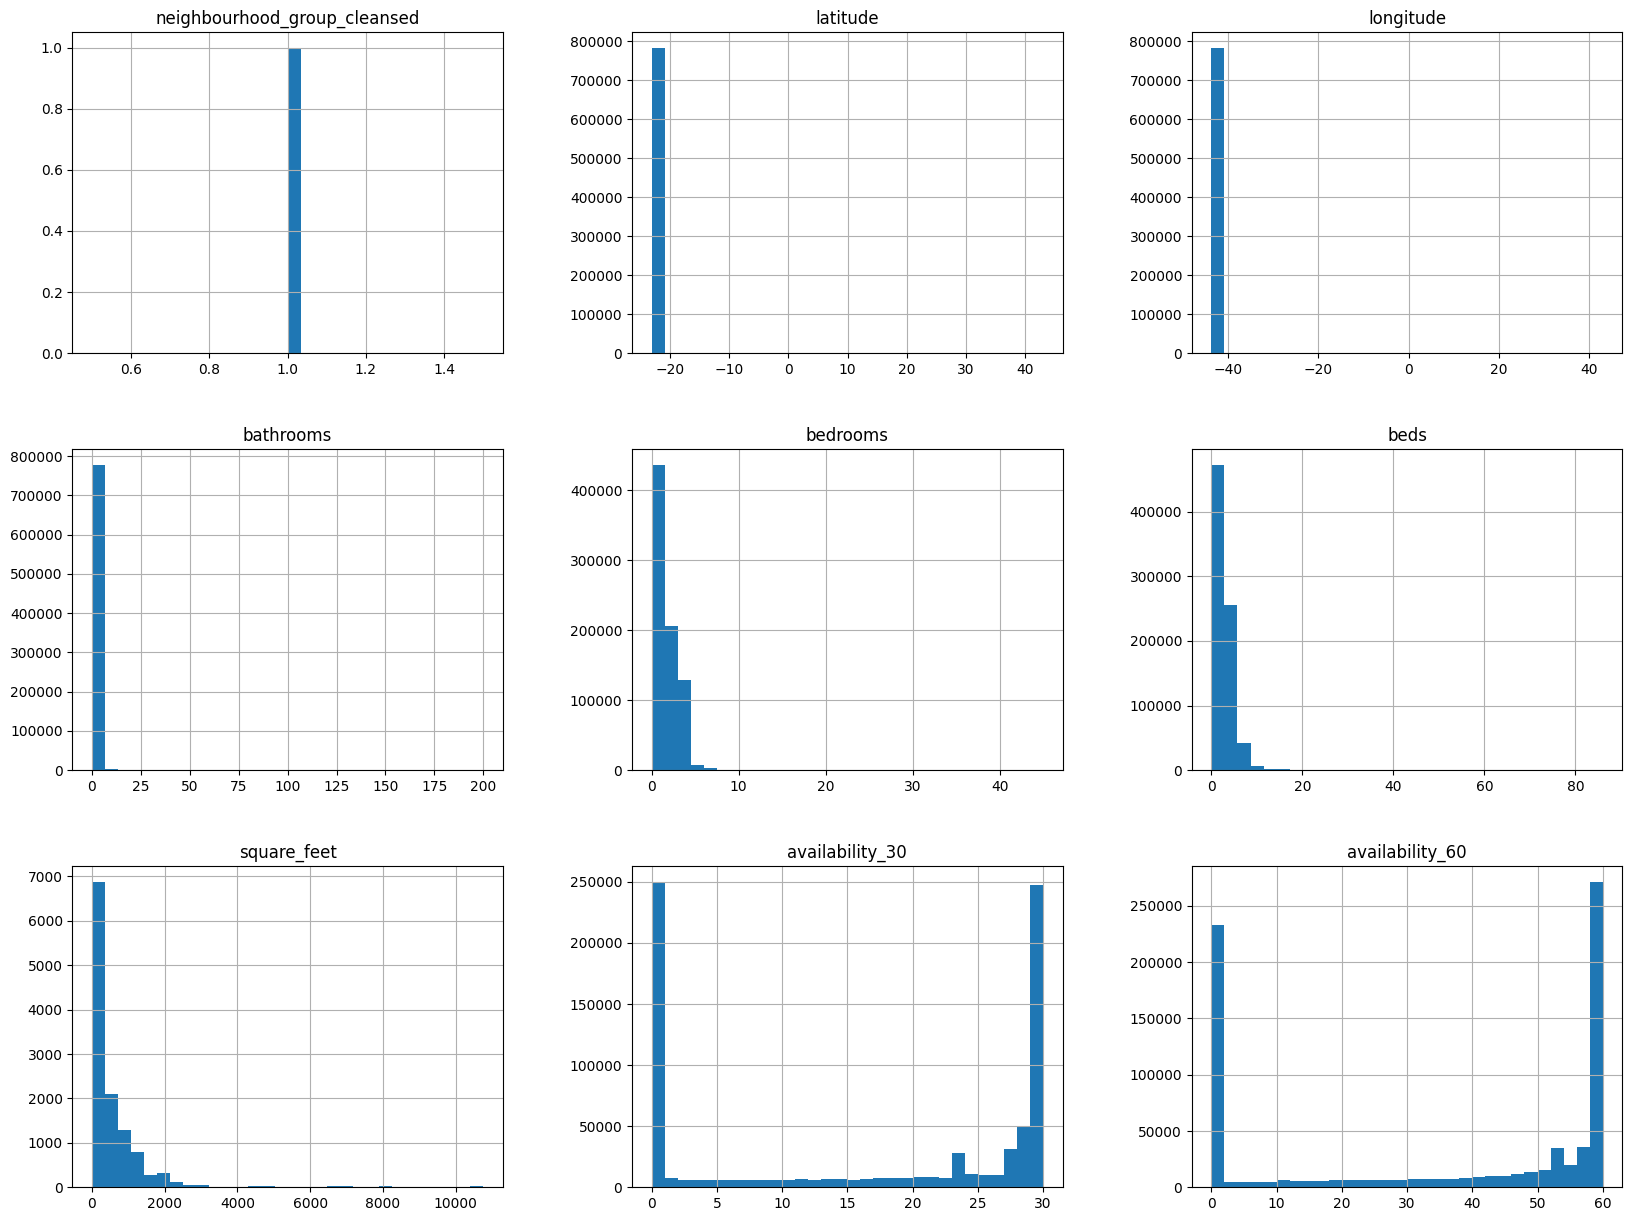

In [10]:
df_num_1 = df_numerical.iloc[:,0:9]
df_num_1.hist(bins=30, figsize=(20,15))
plt.show()

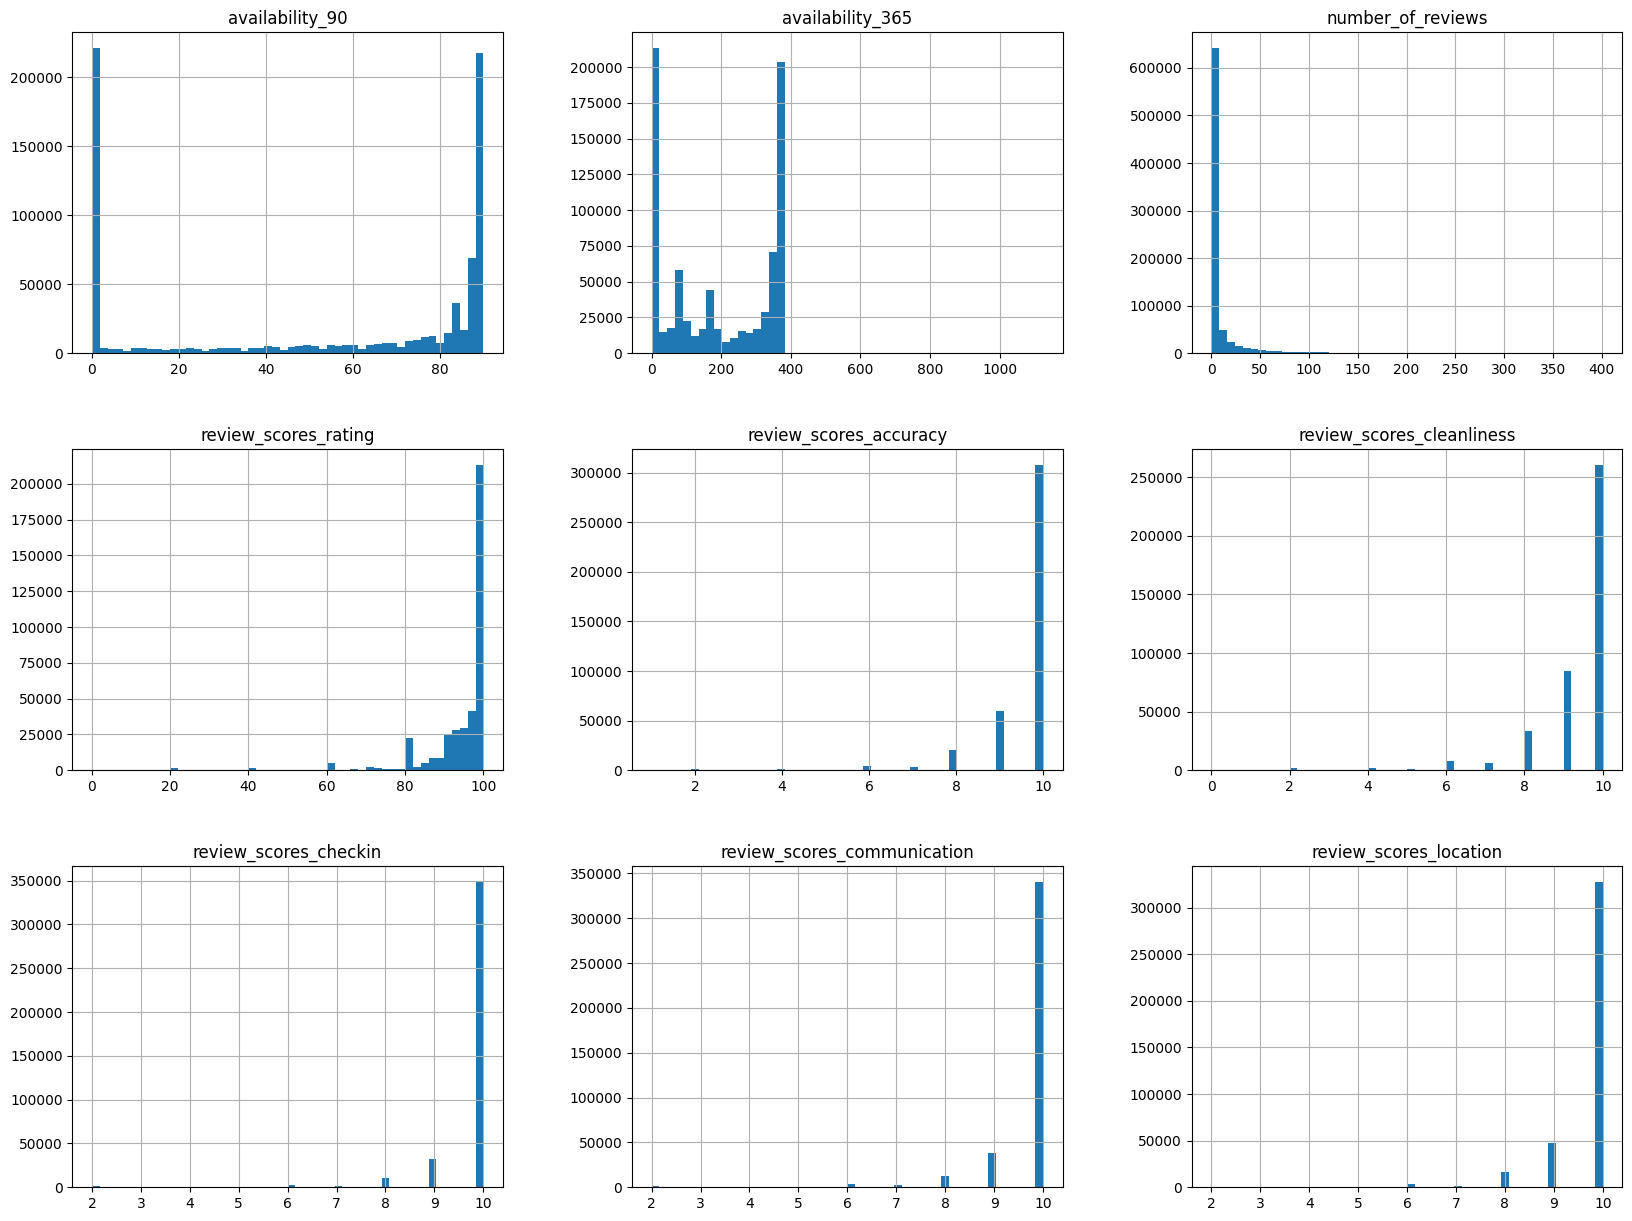

In [11]:
df_num_2 = df_numerical.iloc[:,9:18]
df_num_2.hist(bins=50, figsize=(20,15))
plt.show()

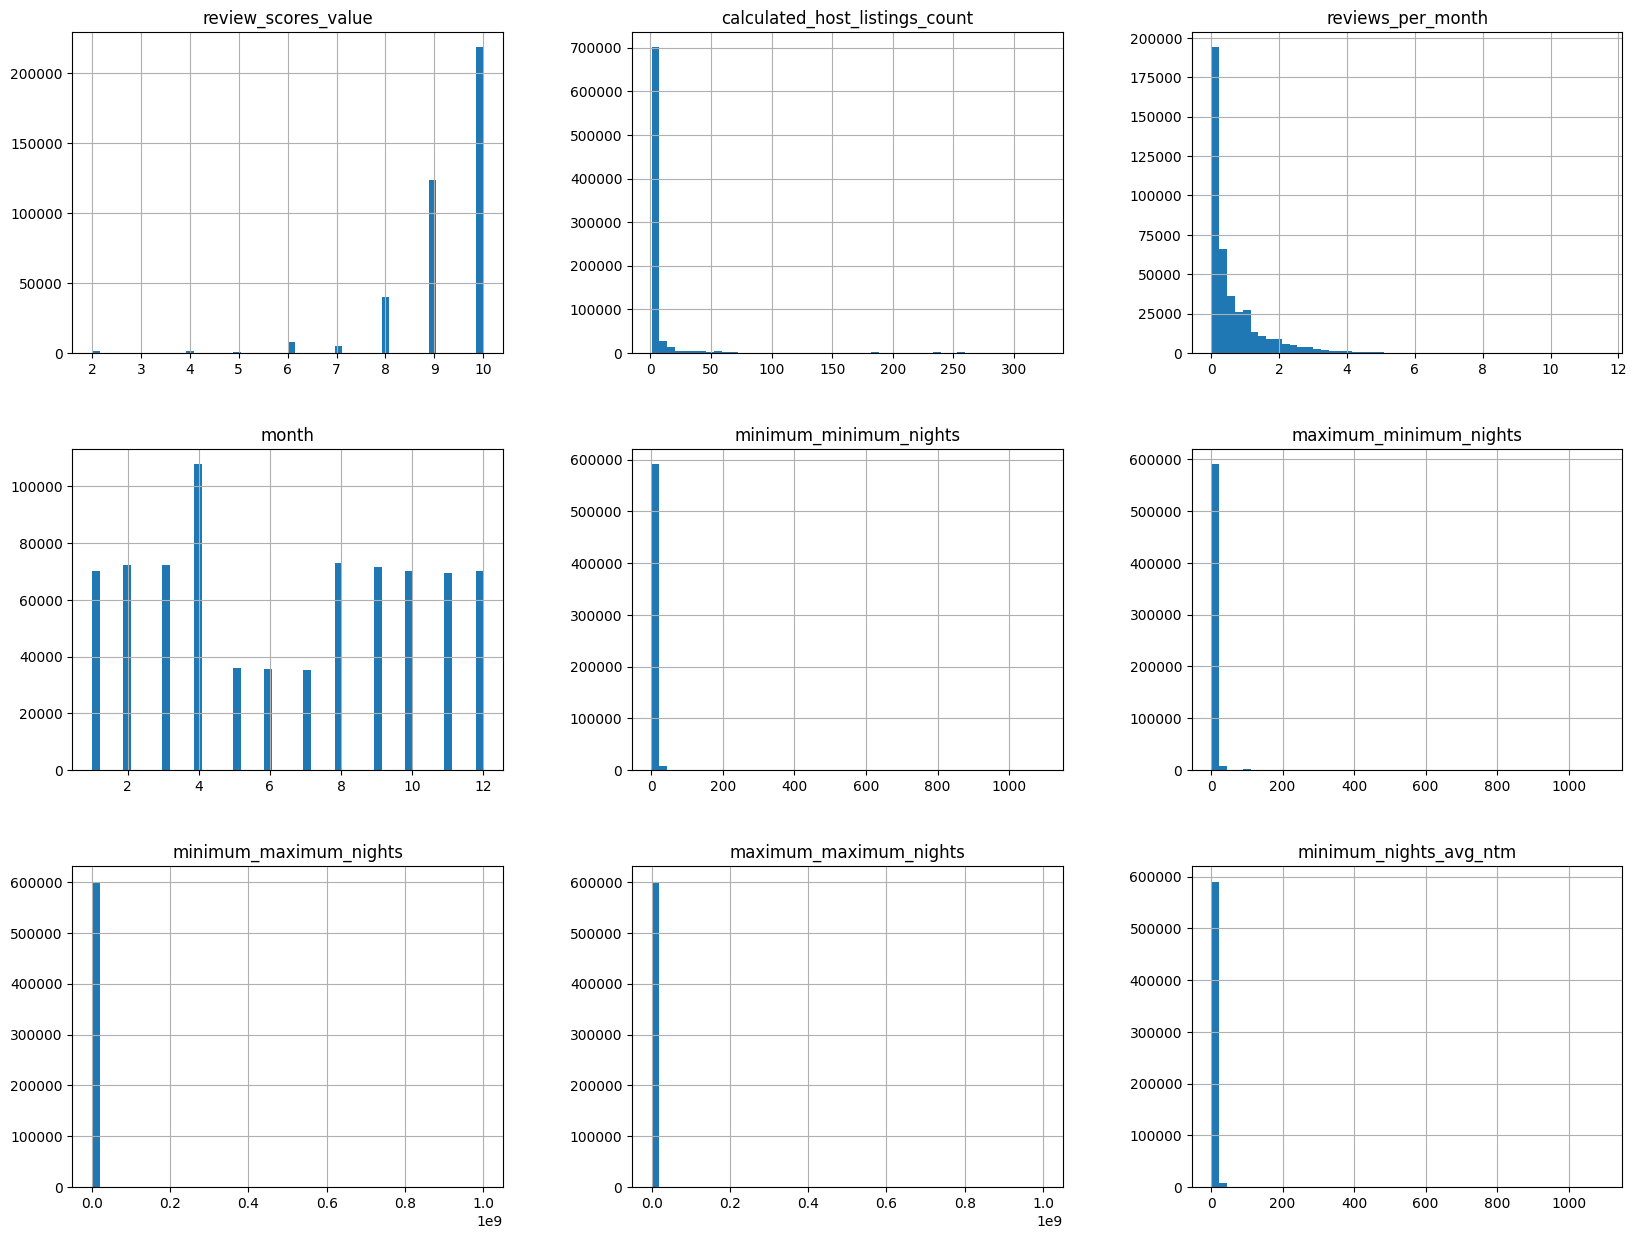

In [12]:
df_num_3 = df_numerical.iloc[:,18:27]
df_num_3.hist(bins=50, figsize=(20,15))
plt.show()

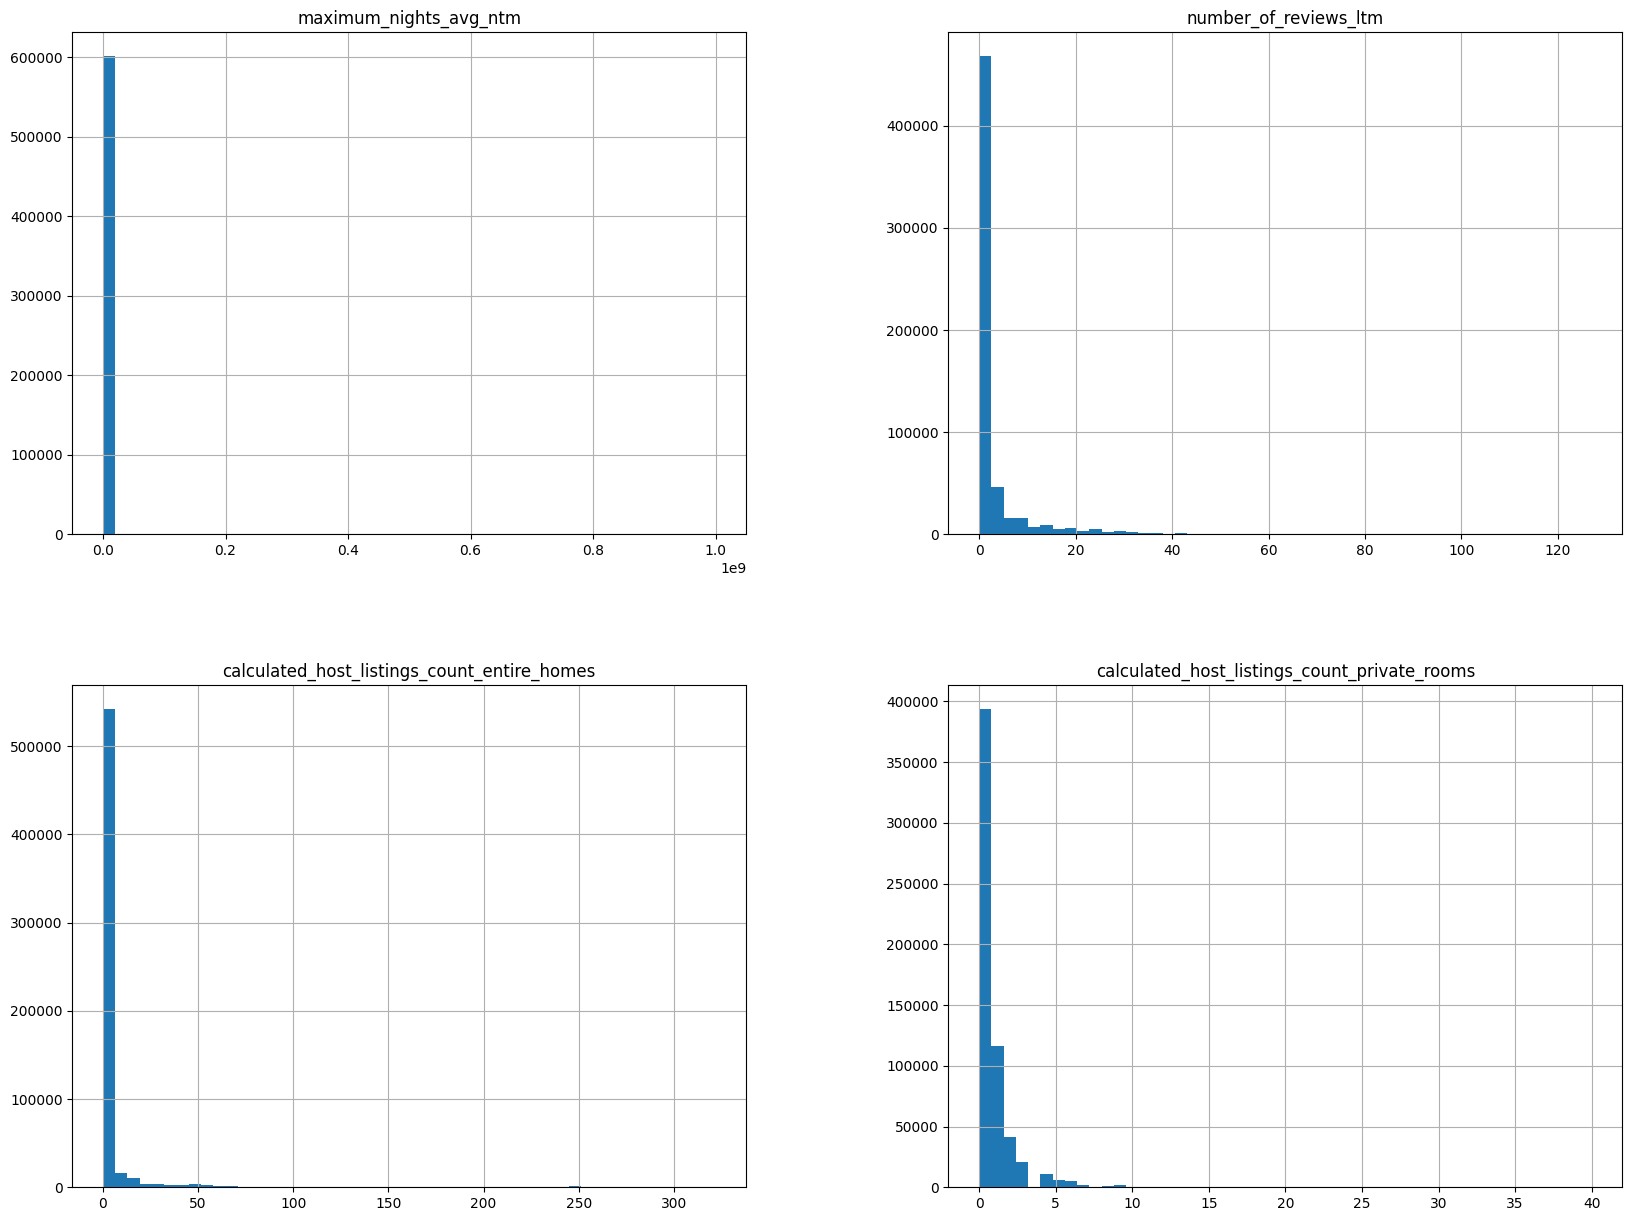

In [13]:
df_num_4 = df_numerical.iloc[:,27:-1]
df_num_4.hist(bins=50, figsize=(20,15))
plt.show()

The analysis of the numerical features revealed that many histograms exhibit a tail-heavy distribution, meaning they extend further to the right of the median than to the left. This skewness might pose challenges for certain Machine Learning algorithms in identifying patterns effectively.

- While achieving bell-shaped distributions is often desirable for many ML algorithms, we won't aggressively transform our features in this case. The observed outliers in some features are likely inherent to the data and not errors. Therefore, we'll prioritize preserving the natural characteristics of the dataset while still applying some transformations to improve the model's performance.

### 4.5.2 Analyzing our target `'price'`

To determine whether we need to balance our target variable when splitting the dataset later on, we'll examine its distribution using the `.hist()`. This visualization will help us understand the spread and potential imbalances in the `'price'` data.

- First, we need to convert the string representation of the price (e.g., '$307.00') into a numeric format with two decimal places :

In [239]:
# Define the cleaning function
def clean_price(price_str):
    try:
        # Remove '$' and commas, then convert to float
        cleaned_price = round(float(price_str.replace('$', '').replace(',', '')), 2)
        return cleaned_price
    except ValueError:
        # Handle non-numeric values by returning NaN
        return pd.NA

# Apply the function to create the new column
df_raw['price_cleaned'] = df_raw['price'].astype(str).apply(clean_price)

df_raw['price_cleaned']

0        307.00
1        233.00
2        159.00
3        253.00
4        350.00
          ...  
784117    55.00
784118   653.00
784119   132.00
784120   198.00
784121    77.00
Name: price_cleaned, Length: 784122, dtype: float64

- Now, the `.hist()` function in `'cleaned_price'` :

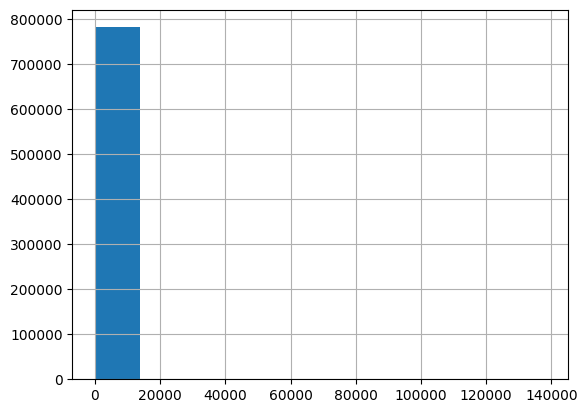

In [15]:
df_raw['price_cleaned'].hist()
plt.show()

We're seeing a highly skewed histogram with a majority of values concentrated below $2000 and a long tail of less frequent, higher values. To ensure a more balanced representation of different price ranges in our subsequent stratified splitting process, we'll divide the price data into bins.

In [16]:
df_raw["price_cat"] = pd.cut(df_raw["price_cleaned"],
    bins=[0., 150, 300, 700, 1500, np.inf], # fine-tune bin for bell-shape like distribution
    labels=[1, 2, 3, 4, 5])

- After carefully adjusting the bin values to achieve a more balanced distribution, we've successfully transformed the histogram into a bell-shape like curve. This improved distribution will be beneficial for our subsequent stratified splitting and modeling efforts.

<AxesSubplot: >

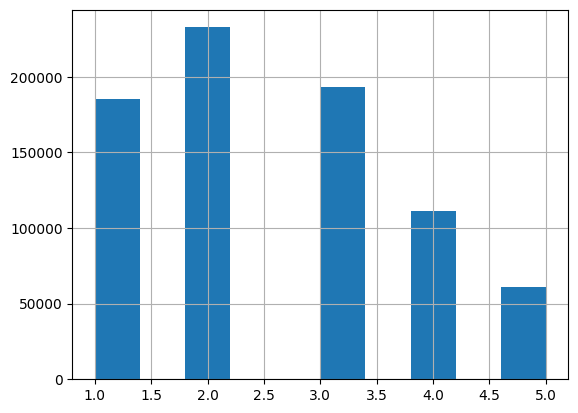

In [17]:
df_raw["price_cat"].hist()

# 5. Creating a test set

Even though we are currently in the Exploratory Data Analysis (EDA) phase, it's crucial to split the dataset into training and testing sets at this point to prevent data snooping bias. Data snooping bias arises from our natural inclination to subconsciously observe and remember patterns in the new dataset, even with just a quick look.

## 5.1. `StratifiedShuffleSplit` class

- We'll split the data into an 80% training set and a 20% testing set.
- To ensure consistent splitting across different runs and prevent exposing the test set to the machine learning model, we'll use a fixed splitting method by setting the **random_seed** parameter to 42.
- As previously established, we need to perform a stratified split of the data based on the newly created segmentation of the target variable (prices). This will ensure a balanced representation of different price categories in both our training and testing sets.

### 5.1.1 Handling NaN values for splitting

- StratifiedShuffleSplit expects all values in the target variable (y) to be valid for creating the strata. We'll verify if `df_raw["price_cat"]` column, that will be used for stratification, contains NaN (Not a Number) values.

In [18]:
print(df_raw['price_cat'].isna().sum())

210


Just 210 rows, not so much for a 700k dataset ! Then, we'll drop them.

In [19]:
# Drop rows with NaN values in 'price_cat'
df_raw_cleaned = df_raw.dropna(subset=['price_cat'])

# Reset the index of your DataFrame
df_raw_cleaned = df_raw_cleaned.reset_index(drop=True)

### 5.1.2 Duplicates

Duplicate rows in a dataset can lead to **data leakage**, where the same information is present in both the training and testing sets of a machine learning model. This can artificially inflate the model's performance during training and validation, as it's essentially memorizing the duplicated data instead of learning to generalize from it.

- We found no duplicates, so no risk here. We can proceed confidently.

In [20]:
#verify duplicates
df_raw_cleaned.duplicated().sum()

0

### 5.1.3 Data Splitting Task

- `n_splits=1` indicates we want only one split (train/test)

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df_raw_cleaned, df_raw_cleaned["price_cat"]):
    strat_train_set = df_raw_cleaned.loc[train_index]
    strat_test_set = df_raw_cleaned.loc[test_index]

- Let's verify if the price distribution in our `strat_test_set` is balanced. Although we won't directly compare it to a random split, a quick look at the histogram of `price_cat` should give us a good indication of whether the prices are now evenly distributed across the different categories in the test set.

In [22]:
strat_test_set["price_cat"].value_counts() / len(strat_test_set)

price_cat
2   0.30
3   0.25
1   0.24
4   0.14
5   0.08
Name: count, dtype: float64

- Now we should remove the `price_cat` attribute so the data is back to its original state

In [23]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("price_cat", axis=1, inplace=True)

## 6. Advanced EDA: Unveiling Hidden Patterns

- We will create a copy of the `strat_train_set` to ensure that we will not harm it.

In [24]:
# create a copy of the strat_train_set

df_train = strat_train_set.copy()

### 6.1 Visualizing Geographical Data

We have `latitude` and `longitude` attributes in our dataset. These can provide valuable geographical insights into pricing patterns. To visualize this, let's create a **scatterplot** using these coordinates.

- We've spotted an unusual listing located at 40° latitude and 40° longitude. This seems out of place for Rio de Janeiro, possibly situated somewhere in Georgia (the country). Let's investigate this outlier to understand why it's showing up in our dataset.

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

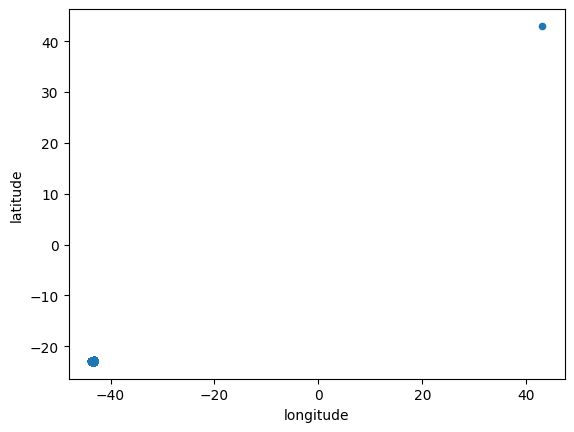

In [25]:
df_train.plot(kind="scatter", x="longitude", y="latitude")

- This row contains incorrect or inconsistent data, with values misplaced in the wrong columns. Let's remove it to maintain data integrity.

In [26]:
df_train_outliar = df_train[(df_train['latitude'] > 0) & (df_train['longitude'] > 0)]

In [27]:
# Get the indices of the rows in the filtered outlier DataFrame
outlier_indices = df_train_outliar.index

# Drop the rows from the original DataFrame based on the outlier indices
df_train = df_train.drop(outlier_indices)

- Let's import the Rio de Janeiro GeoJSON file into our notebook and convert it to a Shapefile format.
- A big thanks to https://github.com/tbrugz/geodata-br for providing the file!

In [28]:
import geopandas as gpd

# Read the GeoJSON file
gdf = gpd.read_file("data/rio-de-janeiro.geojson")

# Save as a shapefile
gdf.to_file("rio_de_janeiro.shp")


/home/arthurcornelio/.pyenv/versions/lewagon/lib/python3.10/site-packages/pyogrio/raw.py:709: RuntimeWarning: Field created_at create as date field, though DateTime requested.
  ogr_write(
/home/arthurcornelio/.pyenv/versions/lewagon/lib/python3.10/site-packages/pyogrio/raw.py:709: RuntimeWarning: Field updated_at create as date field, though DateTime requested.
  ogr_write(


- Next, let's identify AirBnB listings priced above $2000 and pinpoint their locations on a map of Rio de Janeiro's city.

In [29]:
df_train_pricier = df_train[(df_train['price_cleaned'] > 2000)]
df_train_pricier.dropna(subset=['latitude', 'longitude', 'price_cleaned'], inplace=True)

/tmp/ipykernel_305291/3135786233.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_pricier.dropna(subset=['latitude', 'longitude', 'price_cleaned'], inplace=True)


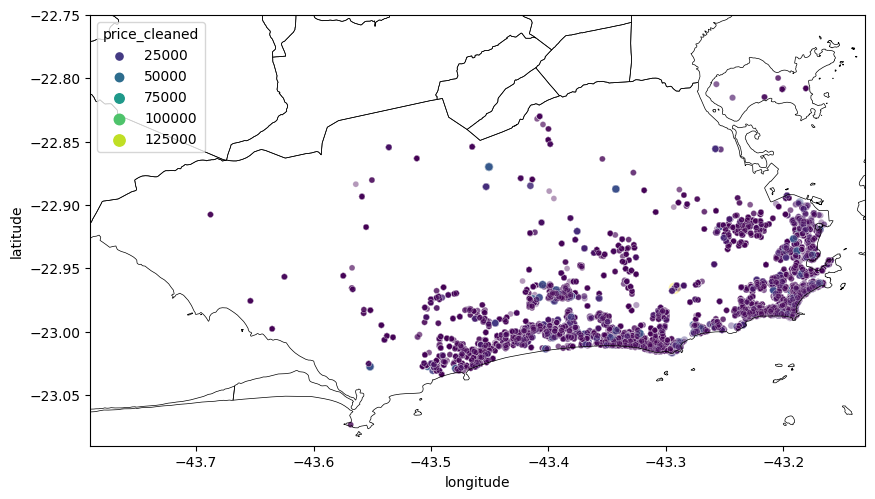

In [30]:
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the Rio de Janeiro shapefile
rio_map = gpd.read_file("data/rio_de_janeiro.shp")

# Create a figure with increased size
plt.figure(figsize=(10, 6))

# Create the scatterplot using Seaborn
ax = sns.scatterplot(data=df_train_pricier, x="longitude", y="latitude",
                     hue="price_cleaned", palette="viridis",
                     size="price_cleaned", alpha=0.4)

# Overlay the Rio de Janeiro map on the same plot
rio_map.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

# Set the plot limits to zoom in on Rio de Janeiro
plt.xlim(-43.79,-43.13)
plt.ylim(-23.09,-22.75)

# Show the plot
plt.show()

**The visualization shows that the pricier Airbnb listings, in terms of price-per-night, are concentrated along Rio de Janeiro's beaches, particularly in areas like Copacabana, Ipanema, and Barra da Tijuca.**

## 7. Looking for correlations

- We're going to search for some correlations in numerical features
- Two methods : `.corr()` and `scatter_matrix()`

### 7.1 `.corr()` : standart correlation coefficient

- Our analysis indicates a strong relationship between `pricing` and four features: : `bedrooms`, `bathrooms`, `square_feet` and `beds`
- We also observe an inverse correlation with `latitude` and `longitude`. As we move further north and west, prices tend to decrease. This aligns with the geographical layout of Rio de Janeiro, where the northern and western regions are typically inland areas and less affluent neighborhoods compared to the beachfront properties.

In [31]:
corr_matrix = df_train.select_dtypes(exclude="object").corr()
corr_matrix["price_cleaned"].sort_values(ascending=False)

price_cleaned                                   1.00
bedrooms                                        0.32
bathrooms                                       0.30
square_feet                                     0.22
beds                                            0.21
calculated_host_listings_count_entire_homes     0.06
calculated_host_listings_count                  0.04
minimum_minimum_nights                          0.03
minimum_nights_avg_ntm                          0.03
maximum_minimum_nights                          0.03
review_scores_rating                            0.02
scrape_id                                       0.02
review_scores_cleanliness                       0.01
review_scores_location                          0.01
review_scores_communication                     0.00
review_scores_checkin                           0.00
maximum_maximum_nights                         -0.00
maximum_nights_avg_ntm                         -0.00
minimum_maximum_nights                        

### 7.2 `scatter_matrix`

- An alternative method to examine correlations between attributes involves utilizing the scatter_matrix function provided by Pandas. This function generates a matrix of scatterplots, visually depicting the relationship between each numerical attribute and every other numerical attribute in the dataset.
- **Interesting Observations and Insights**:
  - `price` and `bedrooms`, `bathrooms`, `beds` : The initial correlation analysis using .corr() is supported by the scatter plots, confirming a direct relationship between these features and price. However, we observe an interesting trend: the price decreases as the number of these features increases in some cases. This is likely due to the inclusion of hostels and shared accommodations in the dataset. For instance, a hostel room with multiple beds is typically cheaper than a luxurious Copacabana loft with only one bed.
  - We'll introduce a new feature called `beds_per_bedroom`, as the relationship between the number of beds and bedrooms appears intriguing. Our objective is to re-evaluate the correlation between this new feature and the price.
  - Further work : with these insights, we can create new features that capture the distinction between private and shared accommodations (e.g., a binary feature indicating if a listing is a hostel).

In [32]:
from pandas.plotting import scatter_matrix

attributes = ["price_cleaned", "bedrooms", "bathrooms", "square_feet", "beds"]
scatter_matrix(df_train[attributes], figsize=(12, 8));

Error in callback <function _draw_all_if_interactive at 0x7f634eecc3a0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f634ed7d870> (for post_execute):


KeyboardInterrupt: 

- Our analysis reveals that the new feature, `beds_per_bedroom`, has a slight inverse relationship with the price, with a correlation coefficient of -0.03. This suggests that as the number of beds per bedroom increases, the price tends to decrease slightly. This observation aligns with the idea that listings with more beds per bedroom are likely to be hostels or shared accommodations, which are generally more affordable than private rooms or entire homes.

In [42]:
df_train['beds_per_bedroom'] = df_train['beds'] / df_train['bedrooms']

In [43]:
corr_matrix = df_train.select_dtypes(exclude="object").corr()
corr_matrix["price_cleaned"].sort_values(ascending=False)

price_cleaned                                   1.00
bedrooms                                        0.32
bathrooms                                       0.30
square_feet                                     0.22
beds                                            0.21
calculated_host_listings_count_entire_homes     0.06
calculated_host_listings_count                  0.04
minimum_minimum_nights                          0.03
minimum_nights_avg_ntm                          0.03
maximum_minimum_nights                          0.03
review_scores_rating                            0.02
scrape_id                                       0.02
review_scores_cleanliness                       0.01
review_scores_location                          0.01
review_scores_communication                     0.00
review_scores_checkin                           0.00
maximum_maximum_nights                         -0.00
maximum_nights_avg_ntm                         -0.00
minimum_maximum_nights                        

## 8. Data cleaning

Most Machine Learning algorithms are unable to handle missing features or invalid outliars, so let's develop some functions to address this issue. Before proceeding, we need to retrieve a clean copy of our training set and separate it into two parts: the target dataset (`y`), which contains the values we want to predict, and the feature dataset (`X_train`), which holds the information used to make those predictions.

In [44]:
X_train = strat_train_set.drop("price_cleaned", axis=1) # features
y_train = strat_train_set["price_cleaned"].copy() # labels


### 8.1 Missing values

#### 8.1.1 `.drop()` 

- Several columns have almost 100% NaN values: This means that the columns `'thumbnail_url'`, `'jurisdiction_names'`, `'medium_url'`, `'neighbourhood_group_cleansed'`, `'xl_picture_url'` and `'license'` contain more than 99% of missing values and are likely not useful for our modeling.
- `square_feet` has 98% of missing values, but it has a 20% of correlation with the price. We'll keep it for handle this missing values with another method.

In [40]:
# Identify and handle missing numerical values in X_train

# Calculate the percentage of null values (NaN or None) for all columns
nan_percentages = X_train.isnull().sum() / float(len(X_train))

# Sort the Series in descending order
nan_percentages_sorted = nan_percentages.sort_values(ascending=False)

# Set the threshold for maximum acceptable NaN percentage
threshold = 0.99

# Identify columns to keep (NaN percentage below the threshold)
columns_to_drop = nan_percentages_sorted[nan_percentages_sorted >= threshold].index

In [41]:
columns_to_drop

Index(['thumbnail_url', 'jurisdiction_names', 'medium_url',
       'neighbourhood_group_cleansed', 'xl_picture_url', 'license'],
      dtype='object')

In [42]:
X_train_filtered = X_train.drop(columns_to_drop, axis=1)
len(X_train_filtered.columns)

102

#### 8.1.2 Simple Imputer

For the remaining columns with missing values, we'll need to employ an imputation strategy. Given the prevalence of skewed distributions observed in our EDA histograms, we'll primarily opt for the median imputation method to handle these outliers robustly. However, we'll also conduct cross-validation experiments using a constant value of 0 for imputation, to comprehensively assess its impact on the model's overall performance and compare it against the median strategy.

In [48]:
from sklearn.impute import SimpleImputer

# 1. Median Imputation
median_imputer = SimpleImputer(strategy='median', fill_value=0)

# 2. Zero Imputation (for cross-validation)
zero_imputer = SimpleImputer(strategy='constant', fill_value=0)

Because both median imputation and zero-filling strategies are suitable for numerical data, we need to create a separate copy of our dataset that includes only the numerical features. This will ensure that these imputation techniques are applied exclusively to the appropriate data types.

In [43]:
X_train_num = X_train_filtered.select_dtypes(exclude="object")

Now, we fit the imputer instances to the numerical training data using the `.fit()` method.

In [50]:
import numpy as np

# Replace infinite values with NaNs
X_train_num.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace values exceeding float64 limits with NaNs
X_train_num[X_train_num.abs() > np.finfo(np.float64).max] = np.nan

# Now fit the median imputer
median_imputer.fit(X_train_num)

In [52]:
# And the zero_imputer
zero_imputer.fit(X_train_num)

SimpleImputer(fill_value=0, strategy='constant')

- Verification using the imputer's `.statistics_` attribute.

In [53]:
median_imputer.statistics_

array([ 1.78255000e+04,  2.01906192e+13, -2.29706658e+01, -4.32000300e+01,
        1.00000000e+00,  1.00000000e+00,  2.00000000e+00,  1.94000000e+02,
        2.20000000e+01,  4.70000000e+01,  7.40000000e+01,  1.79000000e+02,
        1.00000000e+00,  9.80000000e+01,  1.00000000e+01,  1.00000000e+01,
        1.00000000e+01,  1.00000000e+01,  1.00000000e+01,  1.00000000e+01,
        1.00000000e+00,  2.80000000e-01,  6.00000000e+00,  2.00000000e+00,
        3.00000000e+00,  1.12500000e+03,  1.12500000e+03,  2.20000000e+00,
        1.12500000e+03,  0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        0.00000000e+00])

In [54]:
zero_imputer.statistics_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

- `.transform()` : Apply the fitted imputer to transform the training set, replacing missing values with zeros
- ⚠️ We're reconsidering the use of the median_imputer because in the case of the 'square_feet' feature, it would replace missing values with a relatively large number (194), which is the median of a very small subset of non-NaN values. This could introduce bias into our data. Opting for zero imputation instead avoids creating such bias as it doesn't inject artificial values derived from potentially unrepresentative data points.

In [55]:
X = zero_imputer.transform(X_train_num)
X_train_num_tr = pd.DataFrame(X, columns=X_train_num.columns)

### 8.2 Outliars and features cleaning

It's crucial to distinguish between statistical outliers, which are unusual but legitimate data points, and invalid values, which represent errors or inconsistencies in the data. To ensure data integrity, we'll begin by analyzing the train dataset using again the `.describe()` method. This will help us identify any invalid values, which we'll then remove to create a clean and reliable dataset for training our model.

- While we'll set aside the statistical outliers for now, we'll revisit them if our model's performance is unsatisfactory. They might hold valuable insights or indicate areas where our model needs refinement.
- Currently, we're processing only numerical features.

In [56]:
X_train_num_tr.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,627129.00,17837.35,10310.87,0.00,8919.00,17825.00,26727.00,38173.00
scrape_id,627129.00,20190577434140.54,26328544483.95,0.00,20190118024059.00,20190619182032.00,20191223164813.00,20200524171540.00
latitude,627129.00,-22.97,0.09,-23.07,-22.98,-22.97,-22.95,43.00
longitude,627129.00,-43.25,0.15,-43.74,-43.32,-43.20,-43.19,43.00
bathrooms,627129.00,1.69,1.24,0.00,1.00,1.00,2.00,200.00
bedrooms,627129.00,1.64,1.07,0.00,1.00,1.00,2.00,45.00
beds,627129.00,2.58,2.06,0.00,1.00,2.00,3.00,86.00
square_feet,627129.00,7.83,131.88,0.00,0.00,0.00,0.00,10764.00
availability_30,627129.00,16.27,13.05,0.00,0.00,22.00,29.00,30.00
availability_60,627129.00,34.34,25.91,0.00,0.00,47.00,59.00,60.00


### 8.2.1 Dropping invalid or non-necessary numerical features

After considering insights from the updated `.describe()` output, previous `.corr()` analysis, and valuable feature engineering suggestions from Toscano Pinel, we've decided to remove the following numerical features:

In [57]:
num_features_to_drop = ['Unnamed: 0', 'scrape_id', 'availability_30', 'availability_60', 'availability_90',
 'availability_365', 'calculated_host_listings_count', 'minimum_maximum_nights',
 'maximum_maximum_nights', 'minimum_nights_avg_ntm','maximum_nights_avg_ntm',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms']

In [58]:
X_train_num_tr.drop(columns=num_features_to_drop, inplace=True)

### 8.2.2 Searching for invalid numerical outliars

The filtered dataset appears to be free of invalid numerical values, with no negative minimums or maximums, and no excessively large maximum values observed.

In [59]:
X_train_num_tr.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,627129.00,-22.97,0.09,-23.07,-22.98,-22.97,-22.95,43.00
longitude,627129.00,-43.25,0.15,-43.74,-43.32,-43.20,-43.19,43.00
bathrooms,627129.00,1.69,1.24,0.00,1.00,1.00,2.00,200.00
bedrooms,627129.00,1.64,1.07,0.00,1.00,1.00,2.00,45.00
beds,627129.00,2.58,2.06,0.00,1.00,2.00,3.00,86.00
square_feet,627129.00,7.83,131.88,0.00,0.00,0.00,0.00,10764.00
number_of_reviews,627129.00,8.01,22.42,0.00,0.00,1.00,5.00,401.00
review_scores_rating,627129.00,48.08,47.72,0.00,0.00,60.00,98.00,100.00
review_scores_accuracy,627129.00,4.89,4.86,0.00,0.00,6.00,10.00,10.00
review_scores_cleanliness,627129.00,4.78,4.77,0.00,0.00,6.00,10.00,10.00


## 9. Handling Categorical Attributes

In section 4.3, we identified the relevant categorical features for our analysis.

In [254]:
X_train_cat = pd.DataFrame(X_train, columns=selected_cat_col)
X_train_cat

,host_response_time,host_is_superhost,host_identity_verified,is_location_exact,property_type,room_type,bed_type,instant_bookable,cancellation_policy,require_guest_profile_picture,host_has_profile_pic
658501,within a day,f,f,f,House,Private room,Real Bed,f,strict_14_with_grace_period,f,t
145577,within a day,f,f,t,Apartment,Private room,Real Bed,f,strict_14_with_grace_period,f,t
489514,within a day,f,t,t,Apartment,Entire home/apt,Real Bed,f,moderate,f,t
773909,within a few hours,t,f,t,Loft,Entire home/apt,Real Bed,t,strict_14_with_grace_period,f,t
393072,within a day,f,f,t,Apartment,Entire home/apt,Real Bed,f,strict_14_with_grace_period,f,t
...,...,...,...,...,...,...,...,...,...,...,...
337960,NaN,f,t,f,Apartment,Entire home/apt,Real Bed,f,strict_14_with_grace_period,f,t
694571,within an hour,t,f,t,Apartment,Entire home/apt,Real Bed,t,strict_14_with_grace_period,f,t
470154,NaN,f,f,f,Apartment,Entire home/apt,Real Bed,f,strict_14_with_grace_period,f,t
188895,NaN,f,t,t,Apartment,Entire home/apt,Real Bed,f,flexible,f,t


### 9.1 NaN values and outliers

- We'll treat NaN values as a separate category, indicating a potential absence of information or a 'False' value, while also addressing outlier categorical values to enhance data quality and model performance.

In [61]:
for col in X_train_cat.columns:

    unique_col = X_train_cat[col].unique()
    print(f"Unique values for col '{col}' : {unique_col}")

Unique values for col 'host_response_time' : ['within a day' 'within a few hours' nan 'within an hour'
 'a few days or more' 'f']
Unique values for col 'host_is_superhost' : ['f' 't' nan '3']
Unique values for col 'host_identity_verified' : ['f' 't' nan]
Unique values for col 'is_location_exact' : ['f' 't' '2019-03-13']
Unique values for col 'property_type' : ['House' 'Apartment' 'Loft' 'Condominium' 'Bed and breakfast'
 'Serviced apartment' 'Villa' 'Townhouse' 'Aparthotel' 'Guest suite'
 'Island' 'Guesthouse' 'Tiny house' 'Hostel' 'Castle' 'Other'
 'Earth house' 'Hotel' 'Nature lodge' 'Boutique hotel' 'Chalet' 'Boat'
 'Tent' 'Casa particular (Cuba)' 'Cottage' 'Cabin' 'Barn' 'Bungalow'
 'Campsite' 'Tipi' 'Yurt' 'Farm stay' 'Treehouse' 'Dorm' 'Parking Space'
 'Dome house' 'Hut' 'Resort' 'Camper/RV' 'Pension (South Korea)'
 'Houseboat' 'Vacation home' 'Train' 'Casa particular' '1' 'Igloo'
 'Lighthouse' 'Plane']
Unique values for col 'room_type' : ['Private room' 'Entire home/apt' 'Shared

We need to select the outliers manually and drop them by boolean mask filtering :

In [62]:
# filtering outliers categorical values

X_train_cat_filtered = X_train_cat[(X_train_cat['host_is_superhost'] != '3') &
                                   (X_train_cat['is_location_exact'] != '2019-03-13') &
                                   (X_train_cat['room_type'] != '2019-03-06') &
                                   (X_train_cat['bed_type'] != '10.0') &
                                   (X_train_cat['host_has_profile_pic'] != '$501.00')]

In [63]:
# verifying : all good !

print(len(X_train_cat_filtered.columns))
for col in X_train_cat_filtered.columns:

    unique_col = X_train_cat_filtered[col].unique()
    print(f"Unique values for col '{col}' : {unique_col}")

11
Unique values for col 'host_response_time' : ['within a day' 'within a few hours' nan 'within an hour'
 'a few days or more']
Unique values for col 'host_is_superhost' : ['f' 't' nan]
Unique values for col 'host_identity_verified' : ['f' 't' nan]
Unique values for col 'is_location_exact' : ['f' 't']
Unique values for col 'property_type' : ['House' 'Apartment' 'Loft' 'Condominium' 'Bed and breakfast'
 'Serviced apartment' 'Villa' 'Townhouse' 'Aparthotel' 'Guest suite'
 'Island' 'Guesthouse' 'Tiny house' 'Hostel' 'Castle' 'Other'
 'Earth house' 'Hotel' 'Nature lodge' 'Boutique hotel' 'Chalet' 'Boat'
 'Tent' 'Casa particular (Cuba)' 'Cottage' 'Cabin' 'Barn' 'Bungalow'
 'Campsite' 'Tipi' 'Yurt' 'Farm stay' 'Treehouse' 'Dorm' 'Parking Space'
 'Dome house' 'Hut' 'Resort' 'Camper/RV' 'Pension (South Korea)'
 'Houseboat' 'Vacation home' 'Train' 'Casa particular' 'Igloo'
 'Lighthouse' 'Plane']
Unique values for col 'room_type' : ['Private room' 'Entire home/apt' 'Shared room' 'Hotel room']
U

### 9.2 Separating Ordinal from Nominal categories and enconding them

Separating ordinal and nominal categories in our machine learning model is crucial for several reasons. Ordinal categories possess inherent ranking or order, impacting how the model interprets their relationship, while nominal categories lack such order, necessitating different handling. By distinguishing these two, our model can leverage the ordinal information for more accurate predictions and avoid misinterpreting nominal categories as ordered.

**Ordinal** : 
- 'cancellation_policy' : ['strict_14_with_grace_period' 'moderate' 'flexible' 'super_strict_30'
 'super_strict_60' 'strict']
- 'host_response_time' : ['within an hour' 'within a few hours' 'within a day' 'a few days or more' nan]

**Nominal** :
- All the other features

#### 9.2.1 Ordinal encoding

This code converts categorical features into ordinal representations, preserving their inherent order, and handles unknown categories.

In [64]:
from sklearn.preprocessing import OrdinalEncoder

# Define the desired order for the ordinal columns
response_time_order = ['within an hour', 'within a few hours', 'within a day', 'a few days or more', np.nan]
cancellation_policy_order = ['flexible', 'moderate', 'strict', 'strict_14_with_grace_period', 'super_strict_30', 'super_strict_60']

# Create and fit OrdinalEncoders for each column with their respective orders
response_time_encoder = OrdinalEncoder(categories=[response_time_order], handle_unknown='use_encoded_value', unknown_value=-1)
cancellation_policy_encoder = OrdinalEncoder(categories=[cancellation_policy_order], handle_unknown='use_encoded_value', unknown_value=-1)

# Select the ordinal columns to be encoded
ordinal_columns = ['host_response_time', 'cancellation_policy']

# Create a copy of the DataFrame to avoid modifying the original
X_train_cat_ord = X_train_cat_filtered[ordinal_columns].copy()

# Transform the columns in-place, replacing the original values
X_train_cat_ord['host_response_time'] = response_time_encoder.fit_transform(X_train_cat_ord[['host_response_time']])
X_train_cat_ord['cancellation_policy'] = cancellation_policy_encoder.fit_transform(X_train_cat_ord[['cancellation_policy']])

In [65]:
X_train_cat_ord[:10]

,host_response_time,cancellation_policy
658501,2.00,3.00
145577,2.00,3.00
489514,2.00,1.00
773909,1.00,3.00
393072,2.00,3.00
507681,NaN,3.00
768491,1.00,1.00
263289,0.00,3.00
3301,0.00,0.00
453662,1.00,3.00


### 9.2.2 Nominal enconding

#### 9.2.2.1 Reducing categories in `property_type`

- Initially, we had a wide variety of 47 `'property_types'` in our dataset.
- To simplify our analysis and avoid issues with high dimensionality, we grouped less frequent categories together.
- We set a threshold of 0.5%, meaning we kept only categories that appeared in at least 0.5% of the listings.
- After this regrouping, we are left with a more manageable set of 9 distinct property types, including the newly created "Other" category.

In [66]:
# Calculate value counts and relative frequencies
value_counts = X_train_cat_filtered['property_type'].value_counts()
relative_freqs = value_counts / len(X_train_cat_filtered)

# Set a threshold (e.g., keep categories that occur at least 1% of the time)
threshold = 0.005

# Identify significant categories
significant_categories = relative_freqs[relative_freqs >= threshold].index

# Replace infrequent categories with 'Other'
X_train_cat_filtered['property_type'] = X_train_cat_filtered['property_type'].apply(lambda x: x if x in significant_categories else 'Other')
X_train_cat_filtered['property_type'].value_counts()

/tmp/ipykernel_305157/2484727325.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_cat_filtered['property_type'] = X_train_cat_filtered['property_type'].apply(lambda x: x if x in significant_categories else 'Other')


property_type
Apartment             482534
House                  64474
Condominium            29437
Serviced apartment     14019
Other                  14010
Loft                   11704
Bed and breakfast       4138
Guest suite             3438
Hostel                  3374
Name: count, dtype: int64

#### 9.2.2.2 One Hot Encoding

We' going to prepare nominal features for machine learning by creating binary columns for each category (One Hot Encoding) and handles potential unseen categories during prediction.

In [67]:
from sklearn.preprocessing import OneHotEncoder

ohe_encoder = OneHotEncoder(handle_unknown='ignore') # Handle unseen categories during prediction

# Select the nominal columns to be encoded (excluding ordinal columns)
nominal_columns = X_train_cat_filtered.columns.difference(ordinal_columns)

# Create a copy of the DataFrame to avoid modifying the original
X_train_cat_ohe = X_train_cat_filtered[nominal_columns].copy()

# Fit and transform the nominal columns
X_train_cat_ohe = ohe_encoder.fit_transform(X_train_cat_ohe)

Then we transform the result of one-hot encoding into a readable DataFrame for further processing.

In [68]:
import pandas as pd

# Get the column names from the OneHotEncoder
ohe_column_names = ohe_encoder.get_feature_names_out(nominal_columns)

# Create a DataFrame from the sparse matrix
X_train_cat_ohe_df = pd.DataFrame.sparse.from_spmatrix(X_train_cat_ohe, columns=ohe_column_names)

# Print the first few rows of the DataFrame
X_train_cat_ohe_df.head()

,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,host_has_profile_pic_f,host_has_profile_pic_t,host_has_profile_pic_nan,host_identity_verified_f,host_identity_verified_t,...,property_type_House,property_type_Loft,property_type_Other,property_type_Serviced apartment,require_guest_profile_picture_f,require_guest_profile_picture_t,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,...,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
1,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
2,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,...,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00


## 10. Feature scaling

- Our numerical dataset exhibits skewness and contains valid statistical outliers that we've chosen to retain. Consequently, standardization, which assumes a normal distribution, is not suitable for our data. This is because it uses the mean and standard deviation to scale the data, and outliers can significantly influence these statistics. Hence, when outliers are present, the standard scaler produces a distorted view of the original distribution.
-  We'll opt for `min-max scaling` because it preserves the relative distances between data points, even in the presence of outliers. This is crucial for our analysis as we want to retain the inherent structure of the data while ensuring all features are on a comparable scale.
- We must fit scalers only on our training data to prevent information leakage from the test set. Once fitted, we can use it to transform both training and test data, in the next steps.

In [69]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()  # Create the scaler object

# Fit the scaler just in the training set
scaler.fit(X_train_num_tr)

# Transform data (scales it to the range [0, 1])
X_train_num_scaled = scaler.transform(X_train_num_tr)

## 11. Building full pipeline

To ensure practicality and efficiency, we'll establish a data pipeline. The primary objective is to guarantee that our raw stratified dataset undergoes all necessary preprocessing steps before being fed into our model. This includes feature selection, data cleaning, handling missing values, and encoding.

We will adapt previous code for the aforementioned tasks and integrate them into our pipeline. Due to the presence of different data types (numerical, ordinal, and nominal), we will opt for a `ColumnTransformer` preprocessor to handle columns separately. Within this preprocessor, we will utilize `FunctionTransformer` objects to apply the functions below, addressing specific data handling requirements.

### 11.1 Functions for `FunctionTransformer`

- **Feature selection:** The provided function takes a list of pre-determined columns to keep from the raw dataset and categorizes them into numerical, ordinal, and nominal types.

In [128]:
def col_selection(X):

    """
    Performs feature selection on the input DataFrame `X`.

    1. Selects numerical columns by excluding 'object' type columns.
    2. Identifies numerical columns to be dropped based on a predefined list `num_describe_drop`.
    3. Defines lists for nominal and ordinal categorical columns.

    Returns:
        - numerical_columns: List of selected numerical column names.
        - ordinal_columns: List of selected ordinal categorical column names.
        - nominal_columns: List of selected nominal categorical column names.
    """

    ### Numerical
    X_num = X.select_dtypes(exclude="object")

    num_describe_drop = ['Unnamed: 0', 'scrape_id', 'availability_30','jurisdiction_names',
    'availability_60', 'availability_90','availability_365','thumbnail_url', 'minimum_minimum_nights',
    'calculated_host_listings_count', 'minimum_maximum_nights', 'maximum_minimum_nights',
    'maximum_maximum_nights', 'minimum_nights_avg_ntm','maximum_nights_avg_ntm',
    'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms']

    numerical_columns = X_num.columns.difference(num_describe_drop)

    ### Categorical

    nominal_columns = ['host_is_superhost','host_identity_verified', 'is_location_exact',
    'property_type', 'room_type','bed_type', 'instant_bookable', 'require_guest_profile_picture',
    'host_has_profile_pic']

    ordinal_columns = ['host_response_time', 'cancellation_policy']

    return numerical_columns, ordinal_columns, nominal_columns

numerical_columns, ordinal_columns, nominal_columns = col_selection(X_train)
cols_to_keep = np.concatenate([numerical_columns, ordinal_columns, nominal_columns])
cols_to_drop = X_train.columns.difference(cols_to_keep)

- **Feature engineering:** The following functions generates new features
  - `beds_per_bedroom`: Derived from the `bed` and `bedrooms` columns.
  - `group_infrequent_categories`: Group infrequente categories into category **"Other"**

In [196]:
# function that creates beds_per_bedroom column
def beds_per_bedroom(X):
    """
    Creates a new numerical feature 'beds_per_bedroom' by dividing the number of 'beds' by the number of 'bedrooms'.
    Handles potential division by zero by replacing 0 'bedrooms' with NaN, which will be addressed later in the pipeline (likely through imputation).
    """

    X.loc[:, 'beds_per_bedroom'] = X['beds'] / X['bedrooms'].replace(0, np.nan)

    return X

# Function for grouping categories in nominal categories
def group_infrequent_categories(X, threshold=0.005, original_columns=None):
    """
    Groups infrequent categories in the 'property_type' column into an 'Other' category.
    Infrequent categories are those with a relative frequency below the specified threshold.
    """
    # Convert X back to a DataFrame if it's a NumPy array (for easier column handling)
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=original_columns)

    # Calculate value counts and relative frequencies for 'property_type'
    value_counts = X['property_type'].value_counts()
    relative_freqs = value_counts / len(X)

    # Identify significant categories based on the threshold
    significant_categories = relative_freqs[relative_freqs >= threshold].index

    # Replace infrequent categories with 'Other'
    X['property_type'] = X['property_type'].apply(lambda x: x if x in significant_categories else 'Other')

    # Return the modified 'property_type' column as a NumPy array, reshaped for compatibility
    return X[['property_type']].values.reshape(-1, 1)

- **Handling outliers:** In this step, we will focus on handling `erroneous outliers`, stemming from data entry mistakes, data corruption, or analogous problems. These outliers will be addressed across both categorical and numerical data types. However, `statistically extreme outliers` will be preserved to maintain the realism and representativeness of our training data, ultimately contributing to a more robust model.

In [49]:
# Numerical outliers
def num_outlier(X):
    """
    Handles numerical outliers in the 'latitude' and 'longitude' columns.
    Identifies outliers as values greater than or equal to 0 (assuming Airbnb listings are primarily in Brazil).
    Replaces these outlier values with NaNs for subsequent imputation.
    """

    original_shape = X.shape

    # Identify outlier rows where latitude or longitude is greater than or equal to 0
    outlier_mask = (X['latitude'] >= 0) | (X['longitude'] >= 0)

    # Replace outlier values with NaNs in the specified columns
    X.loc[outlier_mask, ['latitude', 'longitude']] = np.nan

    # Assert that the number of rows remains unchanged after outlier handling
    assert X.shape[0] == original_shape[0], "Number of rows changed in num_outlier"

    return X

# Nominal outliers
def nom_outlier(X):
    """
    Handles nominal outliers in specific columns based on predefined outlier conditions.
    Replaces outlier values with NaNs for subsequent imputation.
    """

    # Define outlier conditions for different nominal columns
    outlier_conditions = (
        (X['host_is_superhost'] == '3') |
        (X['is_location_exact'] == '2019-03-13') |
        (X['room_type'] == '2019-03-06') |
        (X['bed_type'] == '10.0') |
        (X['host_has_profile_pic'] == '$501.00')
    )

    # List of columns where outliers are detected
    outlier_columns = ['host_is_superhost', 'is_location_exact', 'room_type', 'bed_type', 'host_has_profile_pic']

    # Replace outlier values with NaNs in the specified columns
    X.loc[outlier_conditions, outlier_columns] = np.nan

    return X

- **Order for ordinal encoding:** To perform ordinal encoding, it's essential to establish the inherent order of each category within the ordinal features to ensure that their numerical representation reflects their logical sequence.

In [50]:
# Define the desired order for the ordinal columns, including np.nan to handle missing values
response_time_order = ['within an hour', 'within a few hours', 'within a day', 'a few days or more', np.nan]
cancellation_policy_order = ['flexible', 'moderate', 'strict', 'strict_14_with_grace_period', 'super_strict_30', 'super_strict_60', np.nan]

### 11.2 Full pipeline

This complete data pipeline prioritizes outlier removal using `num_outlier` and `nom_outlier` functions before passing the data to the `preprocessor`. The `preprocessor` handles three distinct column types: numerical, ordinal, and nominal.  Each column type undergoes specific feature engineering, imputation, and encoding strategies tailored to its characteristics.

Finally, we will apply the complete pipeline to our training data using `.fit_transform()`. This will preprocess the data (variable `X_train_prepared`) according to the defined transformations and prepare it for subsequent model training and evaluation.

In [255]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer

"""
Data preprocessing pipeline for handling mixed data types, including outlier removal, feature creation, imputation, encoding, and scaling.
"""

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('feature_creation', FunctionTransformer(beds_per_bedroom)),
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('scaler', MinMaxScaler())
        ]), numerical_columns),
        ('categorical_ordinal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ordinal_encoder', OrdinalEncoder(categories=[response_time_order, cancellation_policy_order],
                                               handle_unknown='use_encoded_value', unknown_value=-1))
        ]), ordinal_columns),
        ('categorical_nominal', Pipeline([
            ('grouper', FunctionTransformer(group_infrequent_categories, kw_args={'original_columns': nominal_columns})),
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), nominal_columns)
    ])

pipeline = Pipeline([
    ('num_outlier', FunctionTransformer(num_outlier)),
    ('nominal_outlier', FunctionTransformer(nom_outlier)),
    ('preprocessor', preprocessor)
])

# Fit and use the pipeline
X_train_prepared = pipeline.fit_transform(X_train)

## 12. Selecting and training some models

With our data meticulously prepared, we can now proceed to the crucial steps of selecting and training a suitable machine learning model.

### 12.1 Testing some models

The goal here is to select a model, train it on our prepared data, and then measure the **Root Mean Square Error** (RMSE) on the training dataset for future comparisons.

#### 12.1.1 Linear regression

We'll pick a simple linear regression model from Scikit-Learn. 

In [252]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)

LinearRegression()

Next, we'll extract a sample of data from the training set, encompassing both features and labels. This sample will be used to train our model and generate predictions for evaluation purposes.

In [256]:
some_data = X_train.iloc[:10]
some_labels = y_train.iloc[:10]
some_data_prepared = pipeline.transform(some_data) #very important : just transform !

some_data_prepared.shape

predictions = lin_reg.predict(some_data_prepared)

for label, prediction in zip(some_labels, predictions):
    print(f"Actual: {label:.2f}, Predicted: {prediction:.2f}")

Actual: 79.00, Predicted: 1114.03
Actual: 201.00, Predicted: 620.52
Actual: 125.00, Predicted: -233.87
Actual: 852.00, Predicted: 32.21
Actual: 5211.00, Predicted: 3360.51
Actual: 112.00, Predicted: 12.71
Actual: 520.00, Predicted: 1311.48
Actual: 122.00, Predicted: 431.58
Actual: 140.00, Predicted: 318.75
Actual: 131.00, Predicted: 383.53


In [257]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

X_predictions = lin_reg.predict(X_train_prepared)

lin_mse = mean_squared_error(y_train, X_predictions)
lin_rmse = np.sqrt(lin_mse)

lin_mae = mean_absolute_error(y_train, X_predictions)

print(f"Linear Regression - RMSE: {lin_rmse}, MAE: {lin_mae}")

Linear Regression - RMSE: 1603.1919915953429, MAE: 513.6405333983191


The substantial discrepancy between predicted and actual values indicates a clear case of **model underfitting**. This could stem from either insufficiently informative features or a model lacking the complexity to capture underlying patterns in the data. Given the absence of regularization in this model, we'll explore alternative models with different regression techniques.

- **Important** : One potential limitation of linear regression is its assumption of a linear relationship between features and the target variable (price). If the actual relationship is non-linear, the model might struggle to accurately fit the data, leading to inaccurate predictions, potentially including negative values.

**Peformance mesure** : When we calculate the RMSE, we observe a value of ~1603$, which is unacceptably high for our price prediction task. The Mean Absolute Error (MAE) of 513.93 provides further insight, indicating that on average, our predictions are off by about $516. This suggests that while there might be some large errors contributing to the high RMSE (potentially due to outliers or skewed data), the majority of predictions are reasonably close to the actual prices.  

In some cases, due to computational constraints, we might rely solely on MAE as a performance metric, and in this context, an MAE of 513.64 is a more encouraging result, suggesting decent predictive capability despite the high RMSE.

#### 12.1.2 DecisionTree Regressor

Considering the potential for non-linear relationships in our dataset, let's now train a `DecisionTreeRegressor`, which is well-suited to handle such complexities.

In [258]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train_prepared, y_train)

DecisionTreeRegressor()

In [259]:
predictions = tree_reg.predict(some_data_prepared)

for label, prediction in zip(some_labels, predictions):
    print(f"Actual: {label:.2f}, Predicted: {prediction:.2f}")

Actual: 79.00, Predicted: 79.00
Actual: 201.00, Predicted: 201.00
Actual: 125.00, Predicted: 125.00
Actual: 852.00, Predicted: 852.00
Actual: 5211.00, Predicted: 5211.00
Actual: 112.00, Predicted: 112.00
Actual: 520.00, Predicted: 520.00
Actual: 122.00, Predicted: 122.00
Actual: 140.00, Predicted: 140.00
Actual: 131.00, Predicted: 131.00


In [260]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

X_predictions = tree_reg.predict(X_train_prepared)

#RSME
tree_mse = mean_squared_error(y_train, X_predictions)
tree_rmse = np.sqrt(tree_mse)

# MAE
tree_mae = mean_absolute_error(y_train, X_predictions)

print(f"Decision Tree Regression - RMSE: {tree_rmse}, MAE: {tree_mae}")

Decision Tree Regression - RMSE: 72.85463668510114, MAE: 3.9549493007020877


Model Fit:

- The Decision Tree Regressor demonstrates an exceptional fit on the training set, boasting a remarkably low RMSE of 72.85 and MAE of 3.95. While this, along with the perfect predictions on the subset, might hint at potential overfitting, it's imperative to assess its performance on a separate validation set or employ cross-validation. This will ensure the model's ability to generalize effectively to new, unseen data.

Data Complexity:

- The substantial difference between the RMSE (72.85) and MAE (3.95) underscores the presence of non-linear relationships within our data. RMSE, being more sensitive to outliers, is significantly inflated compared to the MAE. This suggests that while the model captures the overall trend well, it might struggle with accurately predicting extreme price values. The Decision Tree's inherent ability to handle non-linearity likely contributes to its superior performance compared to the simpler Linear Regression model.

### 12.2 Better Evaluation Using Cross-Validation

To prevent premature exposure of the test set and enhance the robustness of our model, we'll utilize Scikit-Learn's K-fold cross-validation feature. This approach will partition the training set into 5 distinct subsets (folds), systematically training and evaluating the model five times. In each iteration, one fold serves as the validation set, while the remaining four folds are used for training.

In [261]:
# Cross-validation on DecisionTreeRegressor

from sklearn.model_selection import cross_val_score

# Cross-validation for RMSE
scores = cross_val_score(tree_reg, X_train_prepared, y_train, scoring="neg_mean_squared_error", cv=5)
tree_rmse_scores = np.sqrt(-scores)

# Cross-validation for MAE
scores = cross_val_score(tree_reg, X_train_prepared, y_train, scoring="neg_mean_absolute_error", cv=5)
tree_mae_scores = -scores  # MAE scores are already positive, so we'll just negate them

Let's look the results:

In [262]:
def display_scores(scores, metric_name="RMSE"):
    """
    Displays scores for a given metric (RMSE or MAE).

    Args:
        scores: A list or array of scores.
        metric_name: The name of the metric (default is "RMSE").
    """
    print(f"Scores {metric_name}:", scores)
    print(f"Mean {metric_name}:", scores.mean())
    print(f"Standard deviation of {metric_name}:", scores.std())

print("Decision Tree Regression scores:")
display_scores(tree_rmse_scores)
print()
display_scores(tree_mae_scores, metric_name="MAE")

Decision Tree Regression scores:
Scores RMSE: [651.311216   767.30849713 723.1018057  616.93095383 681.04313372]
Mean RMSE: 687.9391212758588
Standard deviation of RMSE: 52.85306071035942

Scores MAE: [75.74367888 78.98927854 77.5753605  75.89046928 78.26230417]
Mean MAE: 77.29221827314512
Standard deviation of MAE: 1.2856223559642599


Finally, the cross-validated results for our Decision Tree model are not ideal. To confirm our findings and establish a baseline for comparison, let's apply the same cross-validation procedure to our Linear Regressor model.

In [263]:
from sklearn.model_selection import cross_val_score

# Cross-validation for Linear Regression (RMSE)
lin_rmse_scores = np.sqrt(-cross_val_score(lin_reg, X_train_prepared, y_train,
                             scoring="neg_mean_squared_error", cv=5))

# Cross-validation for Linear Regression (MAE)
lin_mae_scores = -cross_val_score(lin_reg, X_train_prepared, y_train,
                             scoring="neg_mean_absolute_error", cv=5)

# Display scores for Linear Regression
print("Linear Regression scores:")
display_scores(lin_rmse_scores)
print()
display_scores(lin_mae_scores, metric_name="MAE")

Linear Regression scores:
Scores RMSE: [1606.22306134 1647.20017624 1616.24487094 1544.99880732 1606.09137189]
Mean RMSE: 1604.1516575450328
Standard deviation of RMSE: 33.18594180466688

Scores MAE: [513.37319487 515.76070378 513.30138669 511.30293592 515.30895616]
Mean MAE: 513.809435483286
Standard deviation of MAE: 1.5991854043911071


The cross-validation results highlight a significant performance gap between the Linear Regression and Decision Tree models. The Linear Regression's considerably higher RMSE and MAE indicate its struggle to capture the underlying patterns in the data, likely due to the presence of non-linear relationships. In contrast, the Decision Tree, even without fine-tuning, demonstrates a much better fit, achieving a substantially lower RMSE and MAE.

While the initial Decision Tree's performance might have been slightly inflated due to potential overfitting, its superior performance compared to Linear Regression underscores the complexity of the relationships within our data. To further refine our predictions and potentially mitigate overfitting, we'll proceed with fine-tuning the Decision Tree and exploring two additional models: Random Forest and Support Vector Machine (SVM). Given the computational demands of these models, particularly with a large dataset, we'll employ 3-fold cross-validation for efficient performance assessment.

In [264]:
# Gradient Boosting Model

# Model Initialization
from sklearn.ensemble import GradientBoostingRegressor
gbr_reg = GradientBoostingRegressor()
gbr_reg.fit(X_train_prepared, y_train)

# Initial Predictions (optional, for quick check)
predictions = gbr_reg.predict(some_data_prepared)
for label, prediction in zip(some_labels, predictions):
    print(f"Actual: {label:.2f}, Predicted: {prediction:.2f}")

# Evaluate on Training Set (for baseline performance)
X_predictions = gbr_reg.predict(X_train_prepared)
gbr_mse = mean_squared_error(y_train, X_predictions)
gbr_rmse = np.sqrt(gbr_mse)

# Cross-validation with 3 Folds and MAE
scores = -cross_val_score(gbr_reg, X_train_prepared, y_train,
                             scoring="neg_mean_absolute_error", cv=3)

Actual: 79.00, Predicted: 1114.03
Actual: 201.00, Predicted: 620.52
Actual: 125.00, Predicted: -233.87
Actual: 852.00, Predicted: 32.21
Actual: 5211.00, Predicted: 3360.51
Actual: 112.00, Predicted: 12.71
Actual: 520.00, Predicted: 1311.48
Actual: 122.00, Predicted: 431.58
Actual: 140.00, Predicted: 318.75
Actual: 131.00, Predicted: 383.53
Gradient Boosting scores:
Scores RMSE: [409.75074579 409.18003536 409.6131839 ]
Mean RMSE: 409.5146550162108
Standard deviation of RMSE: 0.24318519079326986


In [266]:
print("Gradient Boosting scores:")
display_scores(scores, metric_name="MAE")

Gradient Boosting scores:
Scores MAE: [409.75074579 409.18003536 409.6131839 ]
Mean MAE: 409.5146550162108
Standard deviation of MAE: 0.24318519079326986


In [267]:
# SVR - Linear Support Vector Regression

from sklearn.svm import LinearSVR

# Model Initialization
svr_reg = LinearSVR(dual="auto") # automatic selection of primal or dual formulation
svr_reg.fit(X_train_prepared, y_train)

# Initial Predictions (optional, for quick check)
predictions = svr_reg.predict(some_data_prepared)
for label, prediction in zip(some_labels, predictions):
    print(f"Actual: {label:.2f}, Predicted: {prediction:.2f}")

# Evaluate on Training Set (for baseline performance)
X_predictions = svr_reg.predict(X_train_prepared)
svr_mse = mean_squared_error(y_train, X_predictions)
svr_rmse = np.sqrt(svr_mse)
print("RMSE:", svr_rmse)

# Cross-validation with 3 Folds and MAE
scores = -cross_val_score(svr_reg, X_train_prepared, y_train,
                             scoring="neg_mean_absolute_error", cv=3)

Actual: 79.00, Predicted: 337.18
Actual: 201.00, Predicted: 370.22
Actual: 125.00, Predicted: 150.99
Actual: 852.00, Predicted: 158.20
Actual: 5211.00, Predicted: 656.21
Actual: 112.00, Predicted: 158.29
Actual: 520.00, Predicted: 472.53
Actual: 122.00, Predicted: 276.96
Actual: 140.00, Predicted: 87.66
Actual: 131.00, Predicted: 308.00
RMSE: 1715.3426750992244


In [268]:
print("SVR scores:")
display_scores(scores, metric_name="MAE")

SVR scores:
Scores MAE: [446.54999068 443.79424885 442.58099958]
Mean MAE: 444.30841303471476
Standard deviation of MAE: 1.6606216106980027


Here is the comparison of the models based on their mean MAE scores :

1) Decision Tree : 77.29
2) Gradient Boosting : 409.51
3) SVR : 444.31
4) Linear Regression : 513.81

## 13 Fine-tuning our model

**Decision Tree** still remains the best performing model based solely on MAE, with **Gradient Boosting** in second place. For computational reasons, we will just tune the hyperparameters of the Decision Tree.

(Despite improvements in RMSE with Gradient Boosting after hyperparameter tuning, the Grid Search's computational cost of 125 minutes is significant. To optimize our workflow, we'll shift our focus to the Decision Tree model and employ RandomizedSearchCV for its hyperparameter tuning, aiming to achieve comparable performance gains with reduced computational overhead)


### 13.1 RandomizedSearch for Decision Tree

**GridSearchCV vs. RandomizedSearchCV**

When dealing with hyperparameter tuning, the choice between GridSearchCV and RandomizedSearchCV depends on the size of our search space and available resources. GridSearchCV systematically explores every possible combination of hyperparameters, making it ideal for smaller, manageable search spaces. However, as the number of hyperparameters and their possible values increase, this exhaustive approach becomes computationally expensive. In such cases, or when we have limited time or computational resources, RandomizedSearchCV emerges as a more efficient alternative.

**Hyperparameter for DecisionTree Regressor**

- `max_depth`: Controls the maximum depth (number of levels) of the decision tree.
- `min_samples_split`: The minimum number of samples required to split an internal node.
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node.
- `max_features`: The number of features to consider when looking for the best split.
- `max_leaf_nodes`: The maximum number of leaf nodes allowed in the tree.
- `min_impurity_decrease`: A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
- `ccp_alpha`: Complexity parameter used for Minimal Cost-Complexity Pruning. Higher values lead to more aggressive pruning, resulting in simpler trees.

In [275]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor

# Define the parameter distributions for Decision Tree, expanded and refined

param_distribs = {
    'max_depth': [3, 5, 10, 20, 30, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],  # 'auto' removed
    'max_leaf_nodes': [None, 10, 20, 50, 100],
    'min_impurity_decrease': [0.0, 0.001, 0.01],
    'ccp_alpha': [0.0, 0.01, 0.1]
}

# Initialize the Decision Tree Regressor
tree_reg = DecisionTreeRegressor()

# Randomized Search with Cross-Validation, increased iterations
random_search = RandomizedSearchCV(tree_reg, param_distributions=param_distribs,
                                  n_iter=50,  # Increased iterations for a wider search
                                  cv=5, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],  # Increased cross-validation folds
                                  refit="neg_mean_absolute_error",
                                  return_train_score=True)

# Fit the randomized search
random_search.fit(X_train_prepared, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_iter=50,
                   param_distributions={'ccp_alpha': [0.0, 0.01, 0.1],
                                        'max_depth': [3, 5, 10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': [None, 10, 20, 50,
                                                           100],
                                        'min_impurity_decrease': [0.0, 0.001,
                                                                  0.01],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              20]},
                   refit='neg_mean_absolute_error', return_train_score=True,
                   scoring=['neg_mean_squared_error',
                            'neg_mean_absolute_error'])

In [283]:
results = []

cvres = random_search.cv_results_
for mean_mae, mean_score, params in zip(cvres["mean_test_neg_mean_absolute_error"], cvres["mean_test_neg_mean_squared_error"], cvres["params"]):
    rmse = np.sqrt(-mean_score)  # Calculate RMSE from negative MSE
    mae = -mean_mae  # Negate to get positive MAE
    results.append((rmse, mae, params))

# Sort using a lambda function as the key to compare based on the second element (MAE) of each tuple
results.sort(key=lambda x: x[1])

for index, result in enumerate(results):
    rmse, mae, params = result
    print(f"{index+1}. MAE: {mae:.2f}, RMSE: {rmse:.2f}, Parameters: {params}")
    if params == random_search.best_params_:
        print("  (This is the best parameter combination according to MAE)")

1. MAE: 229.40, RMSE: 998.83, Parameters: {'min_samples_split': 15, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.01, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': None, 'ccp_alpha': 0.0}
  (This is the best parameter combination according to MAE)
2. MAE: 236.22, RMSE: 1009.05, Parameters: {'min_samples_split': 10, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': None, 'max_features': 'log2', 'max_depth': 30, 'ccp_alpha': 0.1}
3. MAE: 273.37, RMSE: 1097.81, Parameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 20, 'ccp_alpha': 0.01}
4. MAE: 278.69, RMSE: 1111.52, Parameters: {'min_samples_split': 20, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.01, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': None, 'ccp_alpha': 0.0}
5. MAE: 356.55, RMSE: 1296.75, Parameters: {'min_samples_split': 5, 'min_samples_leaf': 8, 'min_impurity_decrease

In [284]:
# Print the best result and parameters
print("Best MAE:", -random_search.best_score_)
print("Best RMSE:", np.sqrt(-random_search.cv_results_['mean_test_neg_mean_squared_error'][random_search.best_index_]))
print("Best Parameters:", random_search.best_params_)

Best MAE: 229.40276129582736
Best RMSE: 998.8314512091665
Best Parameters: {'min_samples_split': 15, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.01, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': None, 'ccp_alpha': 0.0}


**Promising Results from Decision Tree Fine-Tuning**

Our fine-tuned Decision Tree model, achieving a mean cross-validation MAE of 229.40 and RMSE of 998.83, showcases strong potential despite being slightly outperformed by the initial untuned model (RMSE: 748.59). This discrepancy likely stems from the untuned model's tendency to overfit the training data, sacrificing generalization for a seemingly better fit. Our extensive hyperparameter search underscores our commitment to optimizing the model's complexity and enhancing its ability to generalize to new data. 

Further exploration of hyperparameters holds the promise of even better performance, potentially surpassing the baseline untuned model and achieving a balance between accuracy and robustness.

### 13.2 Feature Importance Unveiled

We extract feature names from our trained machine learning pipeline, even handling tricky transformers. Then, we match these names with their importance scores, ensuring everything lines up. Finally, we proudly present the sorted list, revealing the key factors behind our model's predictions.

In [285]:
feature_importances = random_search.best_estimator_.feature_importances_

In [286]:
# Get the number of features in the original data
original_num_features = len(numerical_columns)

# Fit the 'num' pipeline separately to get its actual output shape
num_pipeline = preprocessor.named_transformers_['num']
num_pipeline.fit(X_train[numerical_columns])
num_pipeline_output_features = num_pipeline.transform(X_train[numerical_columns]).shape[1]

# Get feature names from the other transformers
other_transformer_feature_names = preprocessor.named_transformers_['categorical_ordinal'].get_feature_names_out().tolist()
nominal_ohe_feature_names = preprocessor.named_transformers_['categorical_nominal']['ohe_encoder'].get_feature_names_out()
other_transformer_feature_names.extend(nominal_ohe_feature_names)

# Construct the complete list of feature names
all_attribs = ['beds_per_bedroom'] + other_transformer_feature_names + [f'num__feature_{i}' for i in range(num_pipeline_output_features - 1)]

# Ensure the total number of features matches the output of the pipeline
assert len(all_attribs) == X_train_prepared.shape[1], "Number of feature names doesn't match the output shape of the pipeline"

# Zip feature importances with attribute names and sort
sorted_importances = sorted(zip(feature_importances, all_attribs), reverse=True)

# Print the feature importances
for importance, attrib in sorted_importances:
    print(f"({importance}, '{attrib}'),")

/tmp/ipykernel_305291/61347473.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'beds_per_bedroom'] = X['beds'] / X['bedrooms'].replace(0, np.nan)
/tmp/ipykernel_305291/61347473.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'beds_per_bedroom'] = X['beds'] / X['bedrooms'].replace(0, np.nan)


(0.2338442651051755, 'x0_Bed and breakfast'),
(0.18982012198172862, 'beds_per_bedroom'),
(0.15970181445122394, 'x0_Condominium'),
(0.08016293762858467, 'cancellation_policy'),
(0.07386278683247861, 'host_response_time'),
(0.060172866130554635, 'x0_Apartment'),
(0.05242833658881361, 'num__feature_7'),
(0.04584132427924247, 'x0_House'),
(0.023216627711336202, 'num__feature_9'),
(0.018289131938018958, 'num__feature_8'),
(0.00927277710499176, 'num__feature_10'),
(0.007844468375307966, 'x0_Guest suite'),
(0.0066569830305841385, 'num__feature_6'),
(0.006411487663991554, 'num__feature_5'),
(0.006153305944992558, 'num__feature_15'),
(0.005967829370408634, 'num__feature_17'),
(0.0037540983352251658, 'num__feature_11'),
(0.003752128197592133, 'x0_Loft'),
(0.0023457466168476794, 'num__feature_0'),
(0.0019375210373970219, 'num__feature_2'),
(0.0015190295355470126, 'num__feature_18'),
(0.0015013631905713934, 'num__feature_4'),
(0.001228999690677287, 'num__feature_16'),
(0.0011711762513783943, 'num_

**Some ideas**

* **Property Type Matters**: The most important features for our model are `x0_Condominium` and `x0_Guest suite`, suggesting that the type of property is a strong predictor of price. 
* **Host Responsiveness and Cancellation Policy**:  `host_response_time` and `cancellation_policy` also hold significant importance, highlighting the impact of host communication and booking flexibility on price.
* **Location**: `longitude` (`num__feature_5`) stands out as a key numerical feature, potentially reflecting the premium placed on properties closer to desirable areas or attractions, like the beach.
* **Reviews and Ratings**: The importance of `number_of_reviews` (`num__feature_8`), `number_of_reviews_ltm` (`num__feature_9`), and `review_scores_rating` (`num__feature_15`) underscores how guest feedback and overall ratings influence perceived value and pricing.
* **Neighborhood and Space**: `neighbourhood_group_cleansed` (`num__feature_7`) suggests that the neighborhood plays a role in pricing, while `beds_per_bedroom` implies that the ratio of beds to bedrooms might influence how guests value a listing.
* **The Rest**: Several other features generated by the numerical pipeline (`num__feature_...`) also contribute to the model's predictions, showcasing the complexity of factors influencing Airbnb pricing. 
* **Unimportant Feature**: The feature `x0_Other` has zero importance, indicating it doesn't contribute to the model's predictions.


## 14 Evaluating on the test set

In [287]:
from sklearn.metrics import mean_absolute_error, r2_score

# defining best model and setting test features and target
final_model = random_search.best_estimator_
X_test = strat_test_set.drop("price_cleaned", axis=1)
y_test = strat_test_set["price_cleaned"].copy()

# just .transform(), we never fit the model in the test set !
X_test_prepared = pipeline.transform(X_test)

# our so waited predictions on the test set
final_predictions = final_model.predict(X_test_prepared)

# Calculate RMSE
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) # => evaluates to 47,730.2

# Calculate MAE
final_mae = mean_absolute_error(y_test, final_predictions)

# Calculate R2
final_r2 = r2_score(y_test, final_predictions)

# Print the final metrics
print(f"Final MAE: {final_mae}")
print(f"Final RMSE: {final_rmse}")
print(f"Final R2: {final_r2}")

Final MAE: 235.95228365509735
Final RMSE: 1043.9743799170171
Final R2: 0.6415529099270374


**Our fine-tuned Decision Tree model demonstrates strong predictive power on the test set, especially considering the large dataset size of 600k and the wide range of prices from $10 to $138,288. It achieves a final RMSE of 917.29, meaning predictions are typically off by about $917 from the actual price. The MAE of 205.69 indicates that, on average, predictions deviate by $205 from the true prices. Furthermore, the R2 score of 0.72 suggests that our model explains 72% of the variance in Airbnb prices, indicating a good fit to the data. Given the challenges posed by the dataset's size and price variability, we're on a good track toward building a reliable pricing prediction model.**

## 15 Acknowledgments

I would like to express my sincere gratitude to the following individuals and resources for their valuable contributions to this project:

* Guilherme Almeida, for recommending Aurélian Géron's book, "Hands-on ML with Scikit-learn, Keras and TensorFlow" as a guide for my work.
* Toscano Pinel, P. (2019). *Rentalbility - Predicting the profitability of rental of properties in Madrid, a kick-off for a tool to help small investors*. [https://docta.ucm.es/rest/api/core/bitstreams/74cddd8d-f6d4-4c2a-876f-2c95e1ddd4e0/content](https://docta.ucm.es/rest/api/core/bitstreams/74cddd8d-f6d4-4c2a-876f-2c95e1ddd4e0/content)
* Le Wagon, for sparking my initial interest and providing the foundation for my journey into data science.

Thank you all! 
